In [304]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from gp import gaussian_process, squared_exponential_cov, matern_5_2, get_covariance_matrix, get_gp_params, get_faster_covariance_matrix, get_gp_params_faster, predict, calculate_ci, plot_ci, calculate_marginal, grid_optimize, get_hyperparameter_grid

# Exercises 6: Linear Smoothing and Gaussian Processes

## Gaussian Processes

#### A) Simulating Gaussian Processes

In [307]:
hyperparameters = {"b":1000, "tau_sq_1": 1, "tau_sq_2": 0}
x=np.linspace(0,1,500)

In [78]:
cov_matrix = np.zeros([len(x), len(x)])
cov_matrix[0,0]
cov_func = squared_exponential_cov
cov_matrix[0,0] = cov_func(x[0], x[0], hyperparameters)

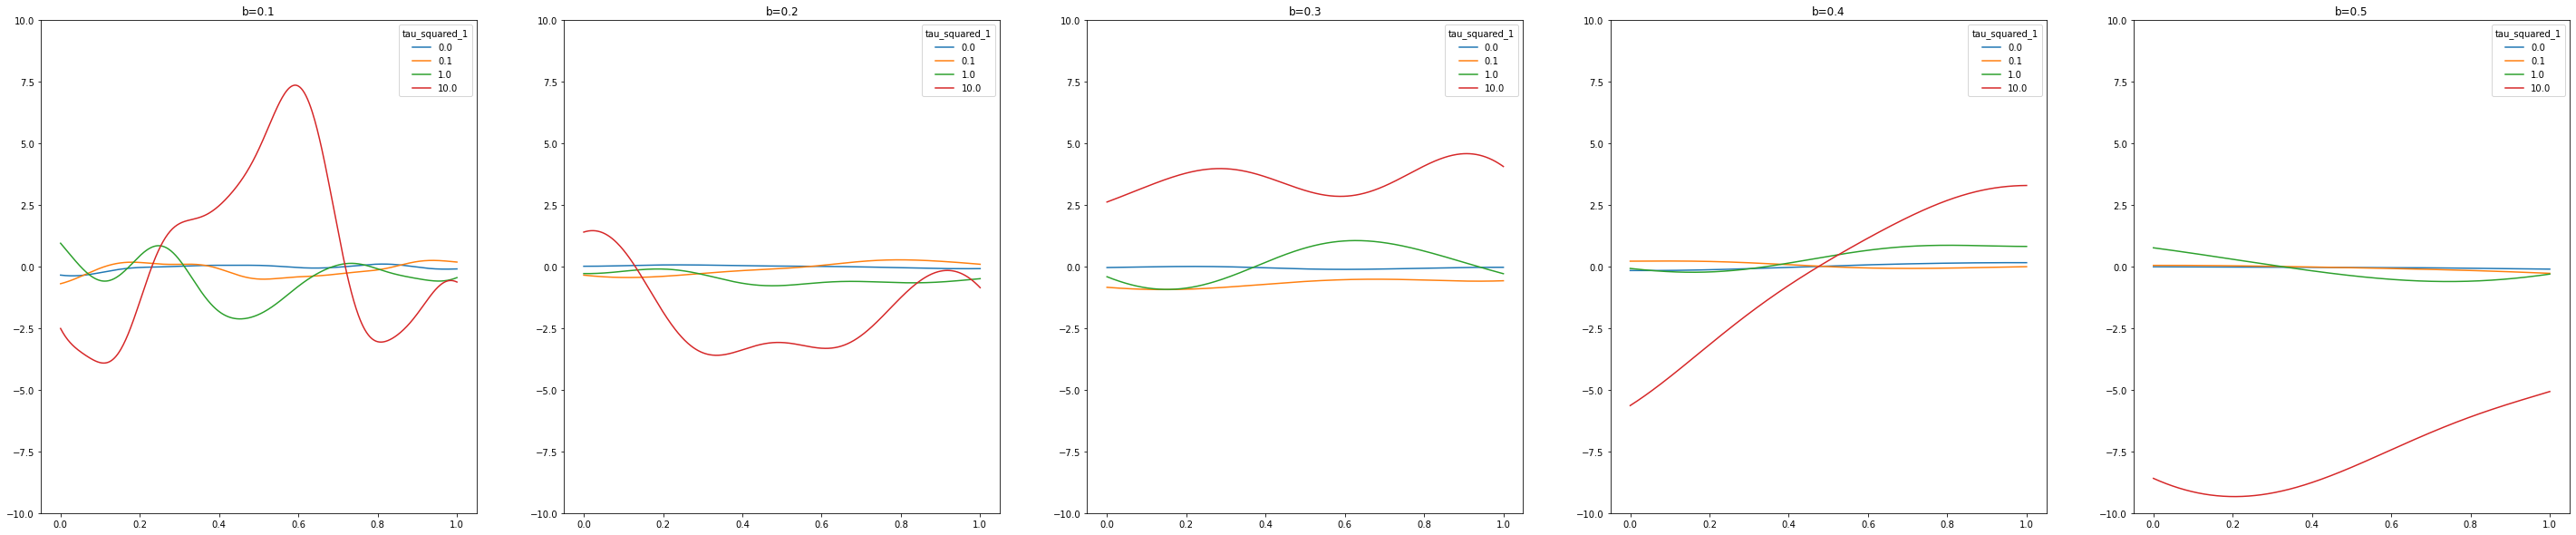

In [308]:
b = np.linspace(.1,.5,5)
t1 = np.array([.01,.1,1, 10])
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_1": t1[j], "tau_sq_2": 0}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, squared_exponential_cov, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_1"], 1)))
        ax.legend(title="tau_squared_1")
        ax.set_ylim(-10,10)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

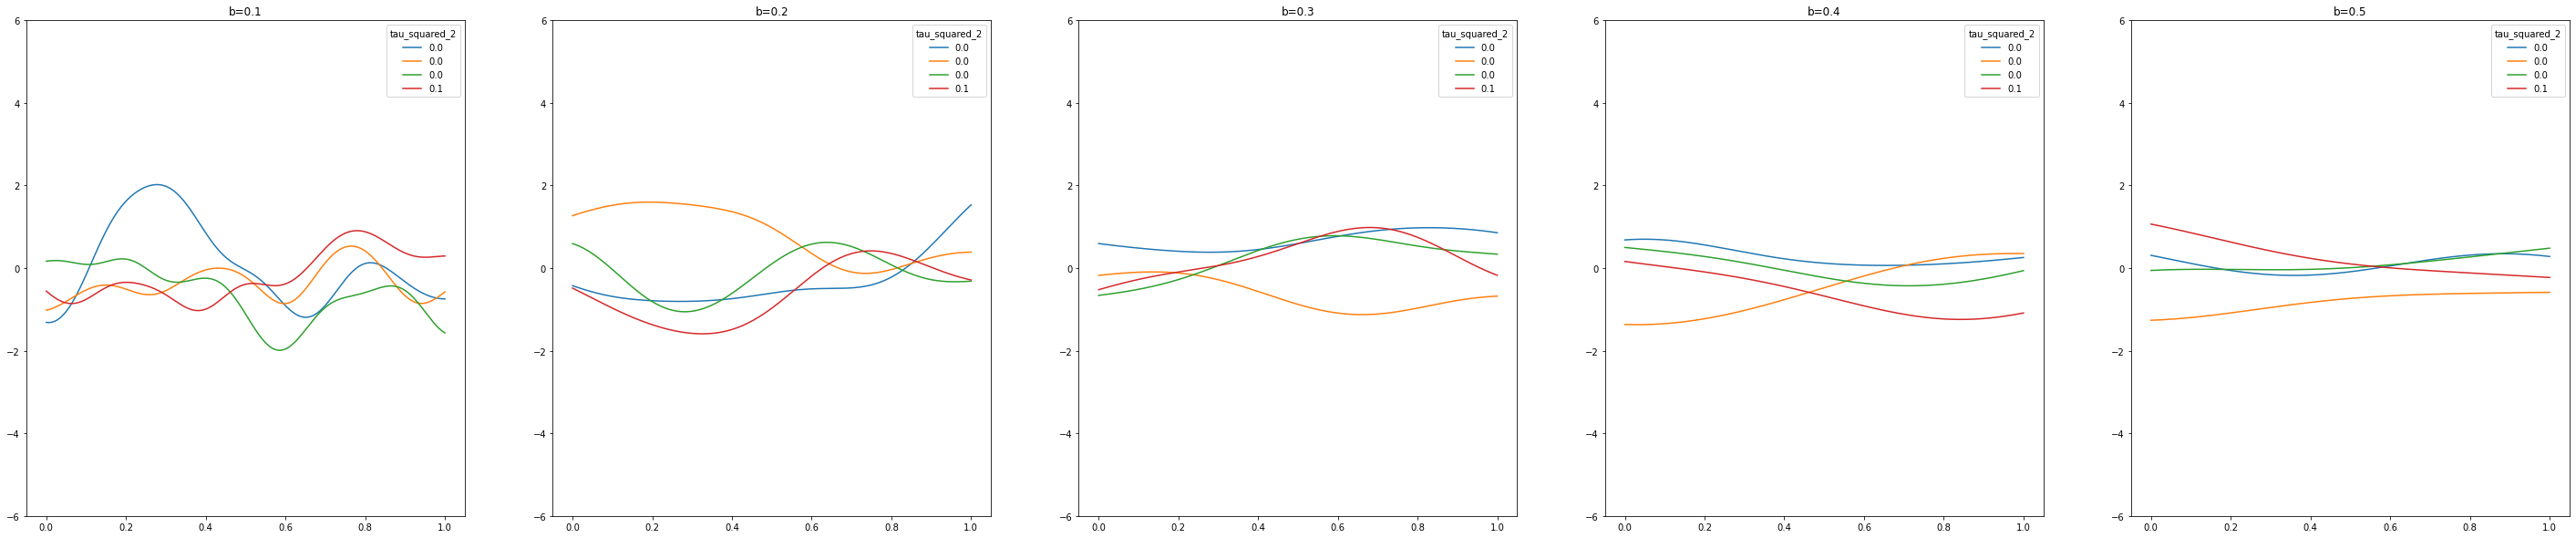

In [125]:
b = np.linspace(.1,.5,5)
t2 = np.array([.00001, .0001, .01, .1])
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_2": t2[j], "tau_sq_1": .5}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, x, squared_exponential_cov, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_2"], 1)))
        ax.legend(title="tau_squared_2")
        ax.set_ylim(-6,6)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

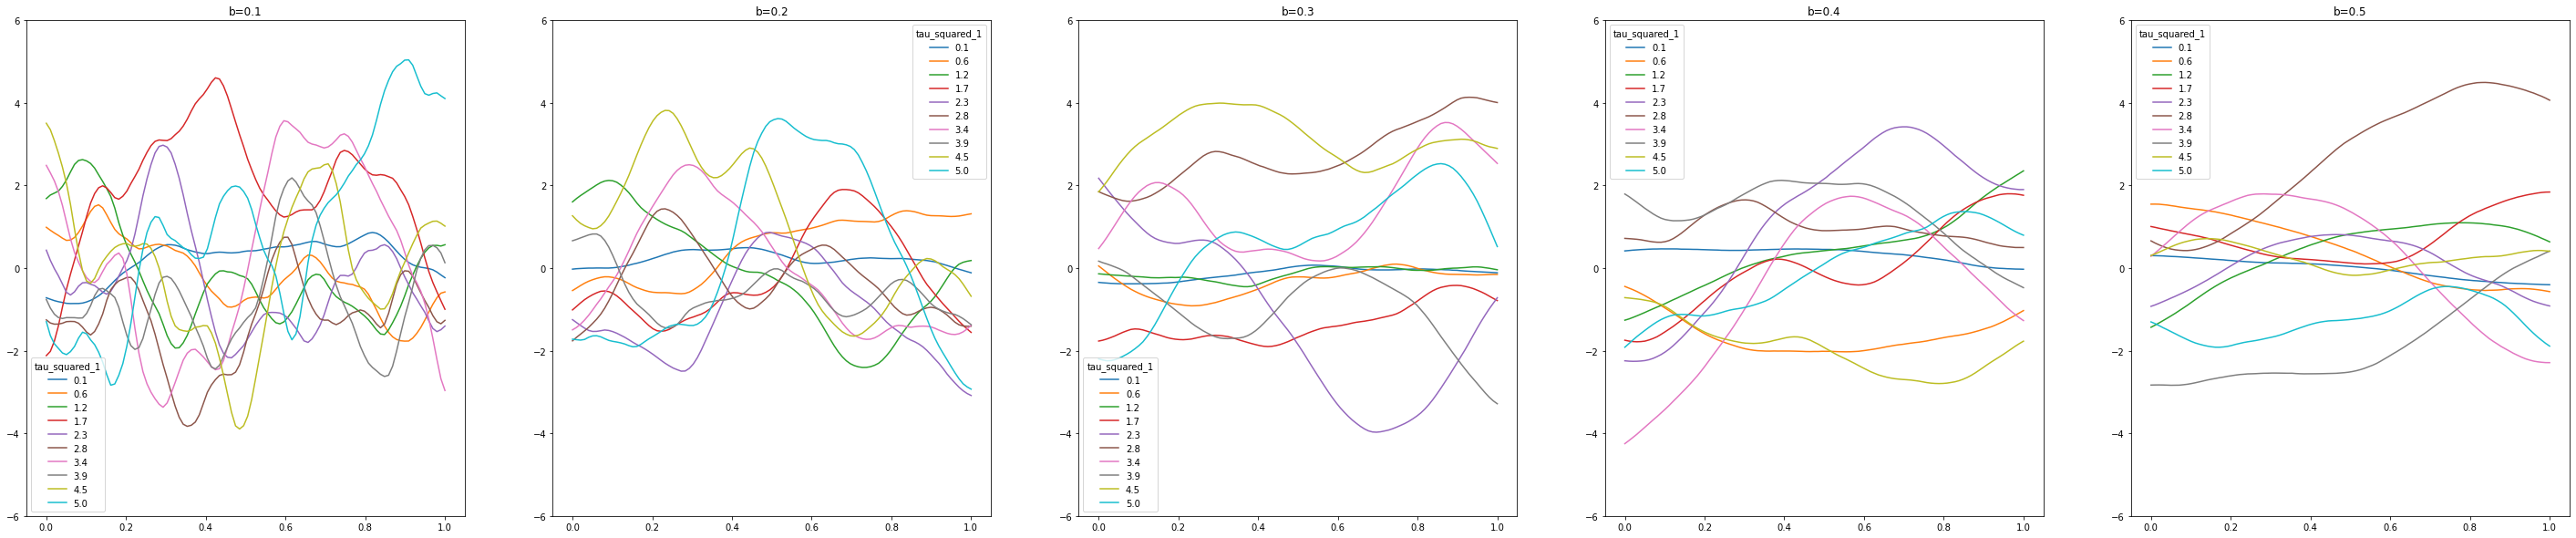

In [80]:
b = np.linspace(.1,.5,5)
t1 = np.linspace(.1,5,10)
fig, axes = plt.subplots(1,5, figsize = (50, 10))
for i, ax in enumerate(fig.axes):
    for j in range(len(t1)):
        hyperparameters = {"b":b[i], "tau_sq_1": t1[j], "tau_sq_2": 10**-6}
        y = multivariate_normal.rvs(mean=np.zeros(len(x)), cov=get_covariance_matrix(x, matern_5_2, hyperparameters))
        ax.plot(x,y, label=str(round(hyperparameters["tau_sq_1"], 1)))
        ax.legend(title="tau_squared_1")
        ax.set_ylim(-6,6)
        ax.set_title("b=" + str(round(hyperparameters["b"],1)))

## Non-parametric Regression and Spatial Smoothing

#### C) Utilities pointwise posterior
Plot the pointwise posterior mean and 95% posterior CI with small t_2^2

In [121]:
utilities = pd.read_csv("../data/utilities.csv").sort_values("temp")

In [127]:
x = np.array(utilities["temp"])
y = np.array(utilities["gasbill"]/utilities["billingdays"])

In [143]:
hyperparameters = {"b":np.std(x), "tau_sq_1": 1, "tau_sq_2": 0}
y_pred, ci = predict(x, y, x, squared_exponential_cov, hyperparameters)

Text(0.5, 0, 'temperature')

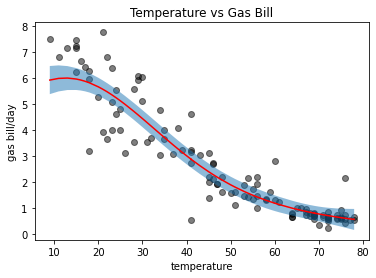

In [174]:
plot_ci(x, y, y_pred, ci)
plt.title("Temperature vs Gas Bill")
plt.ylabel("gas bill/day")
plt.xlabel("temperature")

In [248]:
b_range = [10,20,30,40,50]
tau_sq_1_range = [.1, .5, 1, 5, 10]
hyperparameters = {"b":np.std(x), "tau_sq_1": 1, "tau_sq_2": 0}
y_pred, ci = predict(x, y, x, matern_5_2, hyperparameters)

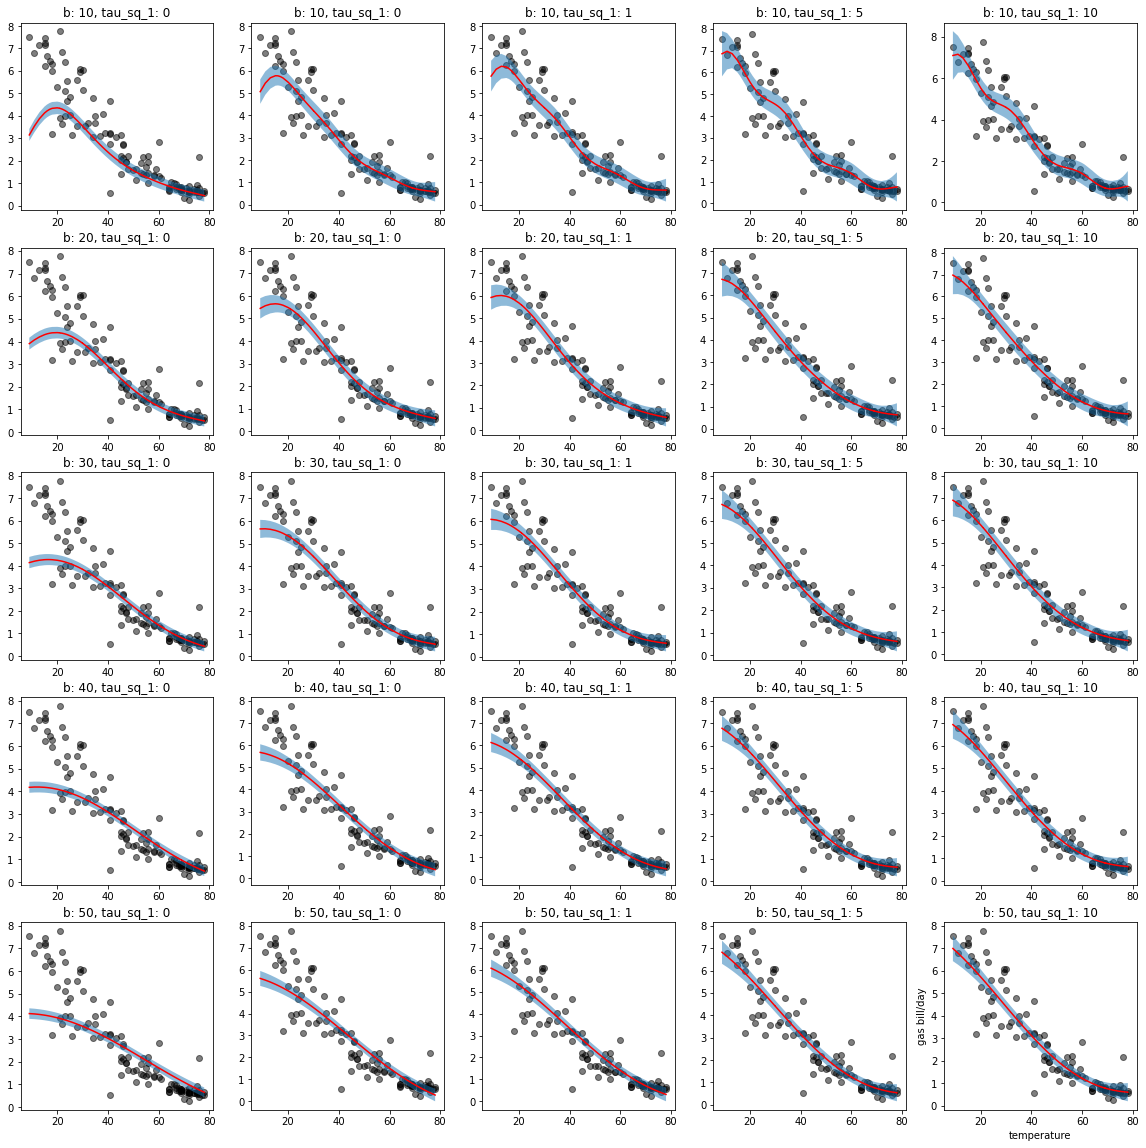

In [249]:
fig, _ = plt.subplots(5,5, figsize=(20,20))
plt.title("Temperature vs Gas Bill")
plt.ylabel("gas bill/day")
plt.xlabel("temperature")
axes = fig.get_axes()
for i in range(len(b_range)):
    for j in range(len(tau_sq_1_range)):
        hyperparameters = {"b":b_range[i], "tau_sq_1": tau_sq_1_range[j], "tau_sq_2": 0}
        y_pred, ci = predict(x, y, x, squared_exponential_cov, hyperparameters)
        plt.sca(axes[int(i*len(b_range)+j)])
        plot_ci(x, y, y_pred, ci)
        plt.title(f"b: {round(b_range[i],1)}, tau_sq_1: {round(tau_sq_1_range[j])}")


#### E) Grid search for params
Fix T_2^2 = 0 and evaluate log of marginal likelihood p(y|T_1^2, b) over a 2d grid; use this to choose a set of T_1^2,b, then use these to compute posterior mean for f given y

In [165]:
calculate_marginal(x, y, squared_exponential_cov, hyperparameters)

-167.60571398317757

In [245]:
hyperparameter_grid = get_hyperparameter_grid(0.01,100,0.01,100,10)
all_marginals, best_pair = grid_optimize(x, y, squared_exponential_cov, hyperparameter_grid)
best_pair

  0%|          | 0/100 [00:00<?, ?it/s]

searching hyperparameters:


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


array([66.67, 44.45])

Text(0, 0.5, 'tau_sq_1')

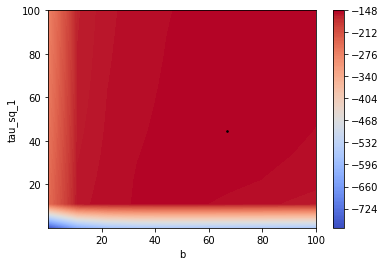

In [247]:
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10)
plt.xlabel("b")
plt.ylabel("tau_sq_1")

searching hyperparameters:: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


[62.22222222 40.        ]


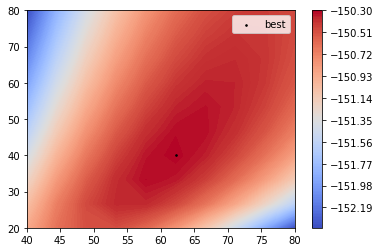

In [250]:
hyperparameter_grid = get_hyperparameter_grid(40,80,20,80,10)
all_marginals, best_pair = grid_optimize(x, y, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


[61.66666667 41.11111111]


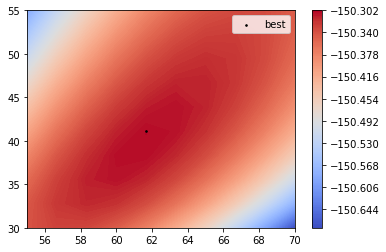

In [251]:
hyperparameter_grid = get_hyperparameter_grid(55,70,30,55,10)
all_marginals, best_pair = grid_optimize(x, y, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


[61.33333333 39.44444444]


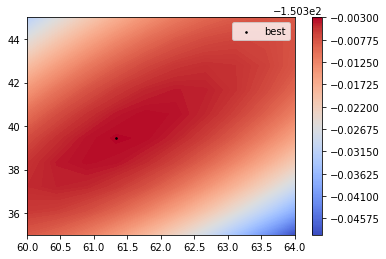

In [257]:
hyperparameter_grid = get_hyperparameter_grid(60,64,35,45,10)
all_marginals, best_pair = grid_optimize(x, y, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

#### F) Weather
Using weather.csv fit a gaussian process for temp and pressure on a grid

In [221]:
import pandas as pd
weather = pd.read_csv("../data/weather.csv")

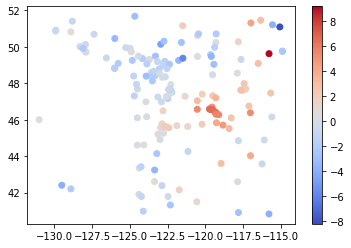

In [222]:
plt.scatter(weather['lon'], weather['lat'], c=weather['temperature'], cmap='coolwarm')
plt.colorbar()

In [223]:
X = np.stack([weather['lon'], weather['lat']]).T
temp = weather['temperature'].to_numpy()
pressure = weather['pressure'].to_numpy()

In [284]:
lon_pred = np.linspace(min([x[0] for x in X]), max([x[0] for x in X]), 100)
lat_pred = np.linspace(min([x[1] for x in X]), max([x[1] for x in X]), 100)
lonlon, latlat = np.meshgrid(lon_pred, lat_pred)
X_pred = np.stack([lonlon.flatten(), latlat.flatten()]).T

searching hyperparameters:: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


[ 0.1 11.2]


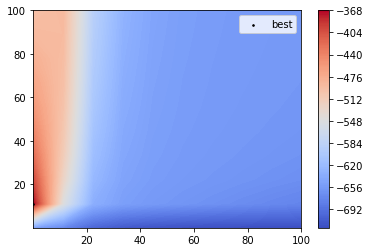

In [258]:
hyperparameter_grid = get_hyperparameter_grid(.1,100,.1,100,10)
all_marginals, best_pair = grid_optimize(X, temp, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[0.67444444 6.        ]


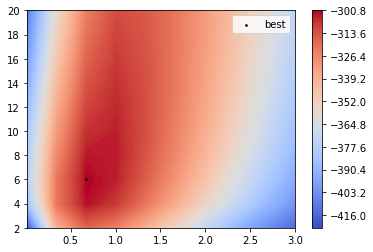

In [259]:
hyperparameter_grid = get_hyperparameter_grid(.01,3,2,20,10)
all_marginals, best_pair = grid_optimize(X, temp, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


[0.73333333 5.77777778]


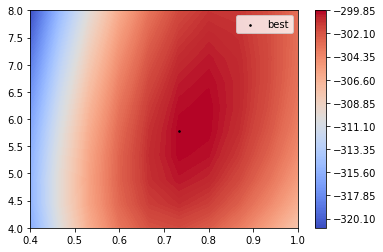

In [260]:
hyperparameter_grid = get_hyperparameter_grid(.4,1,4,8,10)
all_marginals, best_pair = grid_optimize(X, temp, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

In [286]:
hyperparameters = {"b": .7, "tau_sq_1": 5.8, "tau_sq_2": 0}
mean, var, _ = get_gp_params_faster(X, temp, X_pred, hyperparameters)

C:\Users\miles\AppData\Local\Temp\ipykernel_17472\1583585813.py:9: RuntimeWarning: invalid value encountered in sqrt
  plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')


Text(0.5, 1.0, 'std temperature')

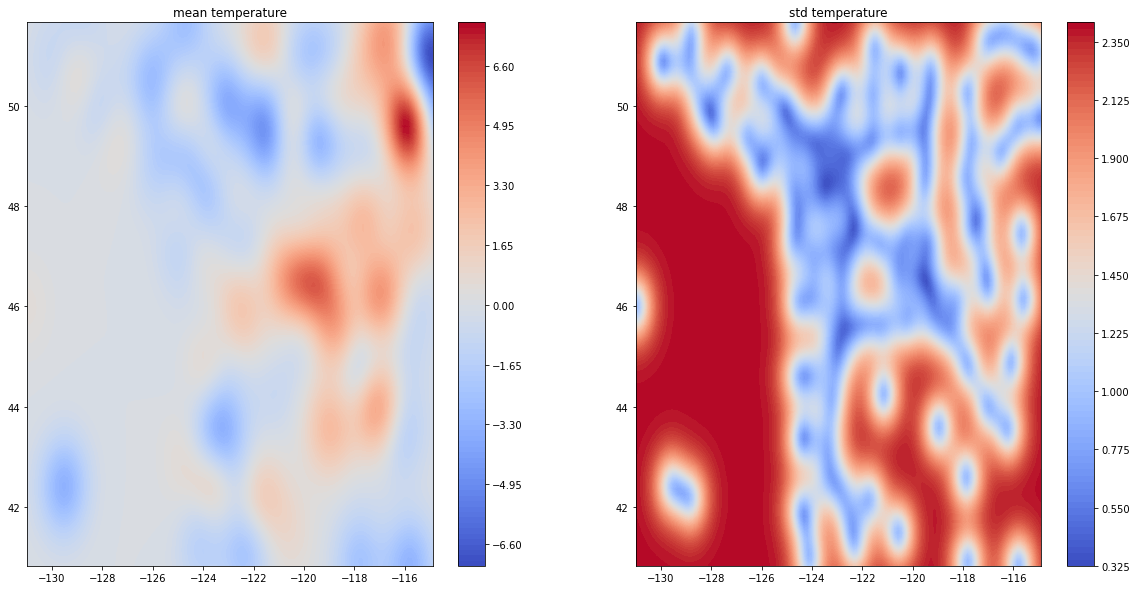

In [288]:
fig, _ = plt.subplots(1,2, figsize=(20,10))
axes = fig.get_axes()
plt.sca(axes[0])
plt.contourf(lon_pred, lat_pred, mean.reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('mean temperature')

plt.sca(axes[1])
plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('std temperature')

In [ ]:
hyperparameter_grid = get_hyperparameter_grid(.1,100,.1,100,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


[  0.1 100. ]


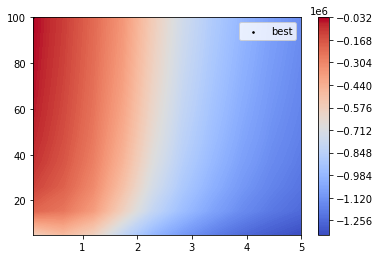

In [290]:
hyperparameter_grid = get_hyperparameter_grid(.1,5,5,100,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

[1.2e-01 1.5e+02]


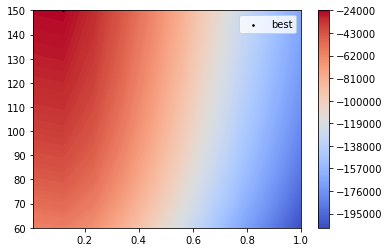

In [291]:
hyperparameter_grid = get_hyperparameter_grid(.01,1,60,150,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


[1.67555556e-01 5.56000000e+04]


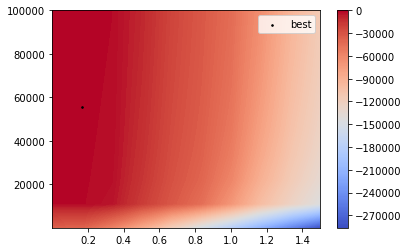

In [292]:
hyperparameter_grid = get_hyperparameter_grid(.001,1.5,100,100000,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


[1.44444444e-01 4.88888889e+04]


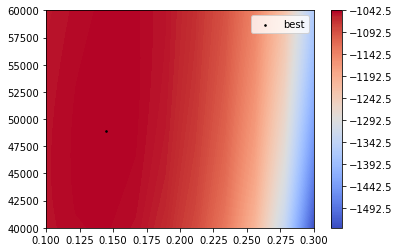

In [294]:
hyperparameter_grid = get_hyperparameter_grid(.1, .3,40000,60000,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


[1.48333333e-01 5.00000000e+04]


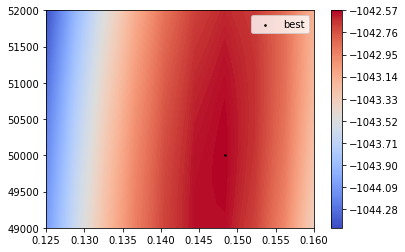

In [296]:
hyperparameter_grid = get_hyperparameter_grid(.125,.16,49000,52000,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

searching hyperparameters:: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


[1.47222222e-01 4.97222222e+04]


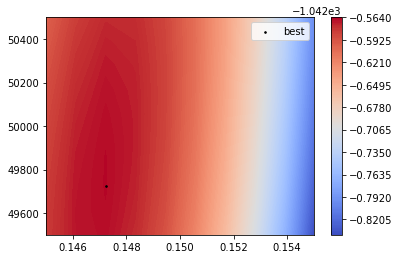

In [297]:
hyperparameter_grid = get_hyperparameter_grid(.145,.155,49500,50500,10)
all_marginals, best_pair = grid_optimize(X, pressure, squared_exponential_cov, hyperparameter_grid)
print(best_pair)
plt.contourf([[x[0] for x in y] for y in hyperparameter_grid], [[x[1] for x in y] for y in hyperparameter_grid], all_marginals, 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(best_pair[0], best_pair[1], color='black', marker='.', s=10, label="best")
plt.legend()

In [300]:
hyperparameters = {"b":.147, "tau_sq_1": 49700, "tau_sq_2": 0}
mean, var, _ = get_gp_params_faster(X, pressure, X_pred, hyperparameters)

C:\Users\miles\AppData\Local\Temp\ipykernel_17472\286475414.py:9: RuntimeWarning: invalid value encountered in sqrt
  plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')


Text(0.5, 1.0, 'std pressure')

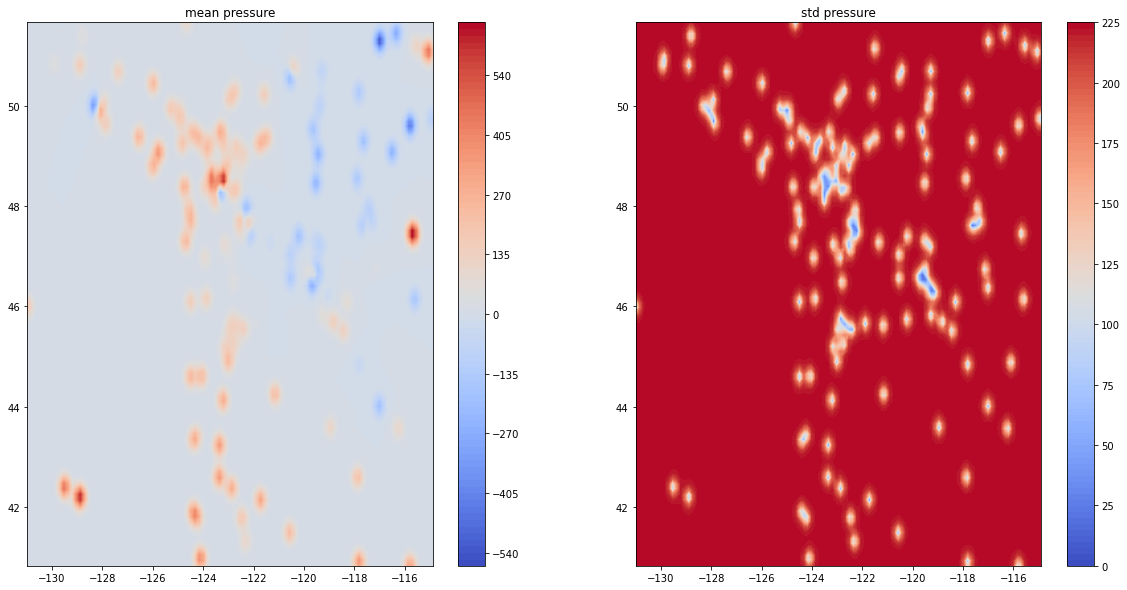

In [302]:
fig, _ = plt.subplots(1,2, figsize=(20,10))
axes = fig.get_axes()
plt.sca(axes[0])
plt.contourf(lon_pred, lat_pred, mean.reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('mean pressure')

plt.sca(axes[1])
plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('std pressure')

This seemed like it needed more smoothing. Running again with higher bandwidth:

C:\Users\miles\AppData\Local\Temp\ipykernel_17472\3051072926.py:11: RuntimeWarning: invalid value encountered in sqrt
  plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')


Text(0.5, 1.0, 'std pressure')

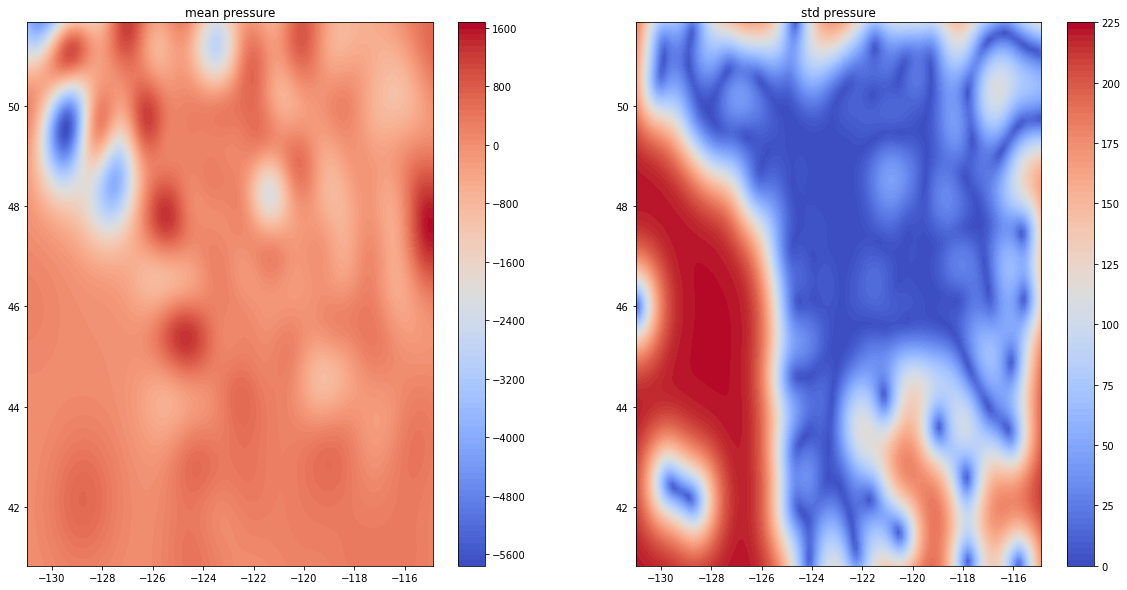

In [303]:
hyperparameters = {"b":1, "tau_sq_1": 49700, "tau_sq_2": 0}
mean, var, _ = get_gp_params_faster(X, pressure, X_pred, hyperparameters)
fig, _ = plt.subplots(1,2, figsize=(20,10))
axes = fig.get_axes()
plt.sca(axes[0])
plt.contourf(lon_pred, lat_pred, mean.reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('mean pressure')

plt.sca(axes[1])
plt.contourf(lon_pred, lat_pred, np.diag(np.sqrt(var)).reshape(100,100), 100, cmap='coolwarm')
plt.colorbar()
plt.title('std pressure')